<a href="https://colab.research.google.com/github/SuzaKrish/Computer-Vision/blob/master/CuratingBuildingofModel_A_Baby_Sitting_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 03 - CNN with Baby Sitting

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import random
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/CV_Project 03_skrish28'

#CNN required libraries
import tensorflow as tf
from tensorflow import keras

#Data Preprocess
from keras.preprocessing.image import ImageDataGenerator

#Model related
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Input, Dropout, Activation, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras import regularizers
from keras.callbacks.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CV_Project 03_skrish28


#Function defintions

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

def plot_curves(ob):
  plt.figure()
  plt.title('Loss plot')
  plt.xlabel('No of epochs')
  plt.ylabel('Loss value')
  plt.plot(ob.history['loss'])
  plt.plot(ob.history['val_loss'])
  plt.legend(['Train loss', 'Val loss'])
  plt.show()

  plt.figure()
  plt.title('Accuracy plot')
  plt.xlabel('No of epochs')
  plt.ylabel('Accuracy value')
  plt.plot(ob.history['accuracy'])
  plt.plot(ob.history['val_accuracy'])
  plt.legend(['Train acc', 'Val acc'])
  plt.show()


#CIFAR10 Data Set 
##This is the extra data set used apart from the face data set.

In [ ]:
from keras.datasets import cifar10
(xtrain, ytrain), (xtest, ytest) = cifar10.load_data()
if(ytrain.shape[1] == 1):
  ytrain = keras.utils.to_categorical(ytrain)
if(ytest.shape[1] == 1):
  ytest = keras.utils.to_categorical(ytest)

print('The CIFAR-10 Data set contains:\n {} training images and its corresponding labels\n Dimension: {}\nLabel dimension: {}'.format(len(xtrain), xtrain.shape, ytrain.shape))
print('The CIFAR-10 Data set contains:\n {} testing images and its corresponding labels\n Dimension: {}\nLabel dimension: {}'.format(len(xtest), xtest.shape, ytest.shape))


170500096/170498071 [==============================] - 3s 0us/step
The CIFAR-10 Data set contains:
 50000 training images and its corresponding labels
 Dimension: (50000, 32, 32, 3)
Label dimension: (50000, 10)
The CIFAR-10 Data set contains:
 10000 testing images and its corresponding labels
 Dimension: (10000, 32, 32, 3)
Label dimension: (10000, 10)


In [ ]:
#Visualize the data
def plot_images(dset, ldset):
  for i in range(10):
    c = 0
    for y in ldset:
      if(y == i):
        print(ldset[c])
        cv2_imshow(dset[c])
        break
      c += 1

print('Training Image check...\n')
plot_images(xtrain, ytrain)
print('Testing Image check...\n')
plot_images(xtest, ytest)

#Choose the training and testing samples from the complete CIFAR 10 dataset

In [ ]:
def vectorize(j):
  e = np.zeros(10)
  e[j] = 1
  return e

In [ ]:
#Training data from original dataset - 50000 images totally
x_train = [np.reshape(x, (3072, 1)) for x in xtrain[:20]]
y_train = [vectorize(i) for i in ytrain[:20]]

#Testing data from original dataset- 10000 images totally
x_test = [np.reshape(t, (3072, 1)) for t in xtest[100:110]]
y_test = [vectorize(i) for i in ytest[100:110]]


#Setting training and testing data for FCN
training_data = []
test_data = []
for i in range(len(x_train)):
  training_data.append((x_train[i], y_train[i]))
for i in range(len(x_test)):  
  test_data.append((x_test[i], ytest[i]))

print('No. of samples in training: {}'.format(len(training_data)))
print('No. of samples in testing: {}'.format(len(test_data)))

No. of samples in training: 20
No. of samples in testing: 10


#Fully Connected Network (FCN) from scratch

###This model uses cross entropy as loss/cost function with activation as sigmoid. The code used was adapted from the following link:
https://github.com/mnielsen/neural-networks-and-deep-learning/blob/d15df08a69ed33ae16a2fff874f83b57a956172c/src/network.py

In [ ]:
class FC_model_scratch(object):

  def __init__(self, sizes):
    self.num_layers = len(sizes)
    self.sizes = sizes
    print('Network topology: {}'.format(self.sizes))
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
    
  def sigmoid(self, val):
    sig = 1/ (1 + np.exp((-1) * val))
    return sig

  def sigmoid_prime(self, val):
    sp = self.sigmoid(val) * (1-self.sigmoid(val))
    return sp

  def FP(self, a, w, b):
    z = (np.dot(w, a) + b)
    a = self.sigmoid(z)
    return a, z

  def SGD(self, training_data, mini_batch_size, epochs, eta, testdata=None,
          traincost = True, testcost = False, trainacc = True, testacc = False, lmbda = 0.0):
    
    trcost, trac = [], []
    evcost, evac = [], []

    print('Training data samples: {}'.format(len(training_data)))
    ntest = 0
    if testdata: 
      ntest = len(list(testdata))
      print('Test Samples: {}'.format(ntest))
    n = len(training_data)
    print(n)
    for j in range(epochs):
      random.shuffle(training_data)
      mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
      
      for mb in mini_batches:
        self.update_mini_batch(mb, eta)
      tcost, ecost, tacc, eacc = 0, 0, 0, 0
      if traincost : 
        tcost = self.cost_cal(training_data)
        trcost.append(tcost)
        #print('Training cost: {}'.format(cost))
      if testcost:
        ecost = self.cost_cal(testdata, convert = True)
        evcost.append(ecost)
        #print('Testing cost: {}'.format(cost))
      if trainacc:
        tacc = self.accuracy(training_data, convert = True)
        trac.append(tacc)
        #print('Accuracy of training: {}/{}'.format(acc, n))
      if testacc:
        eacc = self.accuracy(testdata, convert = False)
        evac.append(eacc)
        #print('Accuracy of testing: {}/{}'.format(acc, ntest))

      print('Epoch {}: TrainLoss:{}, TrainAcc:{}/{}, ValLoss:{}, ValAcc:{}/{}, Lr:{}, Reg:{}'.format(j, tcost, tacc, n, ecost, eacc, ntest, eta, lmbda))
      #print("Epoch {0} complete".format(j))

    return trcost, trac, evcost, evac

  def update_mini_batch(self, mini_batch, eta):
    newb = [np.zeros(b.shape) for b in self.biases]
    neww = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
     # print('Training sample len in minibatch : {}'.format(len(x)))
      delta_newb, delta_neww = self.BP(x, y)
    
      newb = [nb+dnb for nb, dnb in zip(newb, delta_newb)]
      neww = [nw+dnw for nw, dnw in zip(neww, delta_neww)]
      self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, neww)]
      self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, newb)]
  

  def BP(self, x, y):
   # print('Training sample len per minibatch: {}'.format(len(x)))
    newb = [np.zeros(b.shape) for b in self.biases] #New bias for every layer
    neww = [np.zeros(w.shape) for w in self.weights] #New weights for every layer
    
    #Forward pass

    activation = x #Initial activation = Input layer neurons
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer

    for b, w in zip(self.biases, self.weights): #Calculates the activation for every layer
      al, zl = self.FP(activation, w, b)  #Returns the activation, z for one layer
      zs.append(zl)
      activation = al #Reset the activation with the current layer's activation
      activations.append(activation)

    #Backward pass
    delta = self.cost_derivative(activations[-1], y) * self. sigmoid_prime(zs[-1])
    newb[-1] = delta
    neww[-1] = np.dot(delta, activations[-2].transpose())
        
    for l in range(2, self.num_layers):
      z = zs[-l]
      sp = self.sigmoid_prime(z)
      delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
      newb[-l] = delta
      neww[-l] = np.dot(delta, activations[-l-1].transpose())
    
    return (newb, neww)

  def cost_derivative(self, a, y):
    y = np.reshape(y, (y.shape[0], 1))
    #print('Loss: {}'.format(np.linalg.norm(a-y)**2))
    return np.linalg.norm(a - y)**2

  def cross_entrop_cost(self, a, y):
    cel = np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    return cel

  def cost_cal(self, data, lmbda = False, convert = False):
    cost = 0
    for x, y in data:
      #print(x)
      #print(y)
      if convert:
        y = vectorize(y)
      a = self.feedforward(x)
      if lmbda:
        cost += self.cross_entrop_cost(a, y)/len(data)
      else:
        cost += self.cross_entrop_cost(a, y)/len(data)
    if lmbda:
      cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights) 
    
    return cost


  def accuracy(self, data, convert = False):
    sums = 0
    for x,y in data:
      v = np.argmax(self.feedforward(x))#Prediction
      if convert:
        w = np.argmax(y)#If training data, Ground truth is a one hot vector, so convert to one num
      else:
        w = y
      if(v == w):
        sums += 1
    
    return sums
  
  def feedforward(self, a):
    for b, w in zip(self.biases, self.weights):
      prod = np.dot(w, a)
      a = self.sigmoid(np.dot(w, a)+b)
    return a




In [ ]:
#Hyper parameters
ep = 200
lr = [0.001, 0.01, 0.1]
lmbda = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5]
hu = [30, 50]
BS = 20
#loss calculated is for cross entropy

#Plotting curves for the Loss and Accuracies of Training and Testing:
def plot_loss(tr, ev, ep):
  plt.figure()
  plt.title('Loss Curves')
  plt.xlabel('No of epochs')
  plt.ylabel('Loss value')
  plt.plot(tr)
  plt.plot(ev)
  plt.legend(['Train loss', 'Eval data loss'])
  plt.show()

def plot_acc(tr, ev, ep):
  plt.figure()
  plt.title('Accuracy Curves')
  plt.xlabel('No of epochs')
  plt.ylabel('Accuracy value')
  plt.plot(tr)
  plt.plot(ev)
  plt.legend(['Train Accuracy', 'Eval data Accuracy'])
  plt.show()


##Single hidden layer FCN

##No regularization added

In [ ]:
model = FC_model_scratch([3072, hu[1], 10])
trainloss, trainacc, testloss, testacc = model.SGD(training_data, mini_batch_size = BS, epochs = ep, eta = lr[0], testdata = test_data, 
                                                   traincost = True, testcost = True, trainacc = True, testacc = True, lmbda = lmbda[0])


Network topology: [3072, 50, 10]
Training data samples: 20
Test Samples: 10
20
Epoch 0: TrainLoss:229.8539974671794, TrainAcc:0/20, ValLoss:228.28089802424836, ValAcc:0/10, Lr:0.001, Reg:0.0
Epoch 1: TrainLoss:227.83809175509896, TrainAcc:0/20, ValLoss:226.17569776213983, ValAcc:0/10, Lr:0.001, Reg:0.0
Epoch 2: TrainLoss:225.83161091674413, TrainAcc:0/20, ValLoss:224.05983128044156, ValAcc:0/10, Lr:0.001, Reg:0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Epoch 3: TrainLoss:223.8156843947051, TrainAcc:0/20, ValLoss:221.94200550557682, ValAcc:0/10, Lr:0.001, Reg:0.0
Epoch 4: TrainLoss:221.86662321718975, TrainAcc:0/20, ValLoss:219.92769194025735, ValAcc:1/10, Lr:0.001, Reg:0.0
Epoch 5: TrainLoss:220.19830942711627, TrainAcc:0/20, ValLoss:218.15770260578748, ValAcc:1/10, Lr:0.001, Reg:0.0
Epoch 6: TrainLoss:218.7170680576225, TrainAcc:0/20, ValLoss:216.59683189332384, ValAcc:1/10, Lr:0.001, Reg:0.0
Epoch 7: TrainLoss:217.16106905457207, TrainAcc:0/20, ValLoss:214.93339612399268, ValAcc:1/10, Lr:0.001, Reg:0.0
Epoch 8: TrainLoss:215.66012104701548, TrainAcc:0/20, ValLoss:213.3550367167385, ValAcc:1/10, Lr:0.001, Reg:0.0
Epoch 9: TrainLoss:214.23077047439955, TrainAcc:0/20, ValLoss:211.8469103839277, ValAcc:1/10, Lr:0.001, Reg:0.0
Epoch 10: TrainLoss:212.8326671106624, TrainAcc:0/20, ValLoss:210.3684568454022, ValAcc:1/10, Lr:0.001, Reg:0.0
Epoch 11: TrainLoss:211.56889721354312, TrainAcc:0/20, ValLoss:209.04272597021597, ValAcc:1/10, Lr:0.

Plots when no regularization is included in singler hidden layer model: 



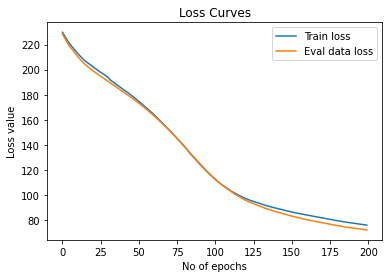

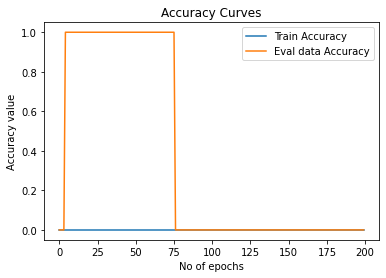

In [ ]:
print('Plots when no regularization is included in singler hidden layer model: \n')
plot_loss(trainloss, testloss, ep)
plot_acc(trainacc, testacc, ep)

###There are few problems with respect to the above model, although we increase the learning rate, it looks like there is not much of a difference in the behaviour of the model.The model learns as we can see that the loss curves for both the training and testing are decreasing. But, this isn't enough.
###Thus adding regularizer and changing the loss function to cross entropy loss, we'll try to see if there is any improvements.

###In order to include the regularizer, we are adding the lambda value while calling the cross entropy loss function.

##Regularization L2 norm added

In [ ]:
#Regularization added - L2 norm

model = FC_model_scratch([3072, hu[1], 10])
trainloss, trainacc, testloss, testacc = model.SGD(training_data, mini_batch_size = BS, epochs = ep, eta = lr[1], testdata = test_data, 
                                                   traincost = True, testcost = True, trainacc = True, testacc = True, lmbda = lmbda[1])


Network topology: [3072, 50, 10]
Training data samples: 20
Test Samples: 10
20
Epoch 0: TrainLoss:94.40245684948867, TrainAcc:1/20, ValLoss:88.55098864508857, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 1: TrainLoss:84.0298104560777, TrainAcc:1/20, ValLoss:79.83717446498794, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 2: TrainLoss:76.33383830449966, TrainAcc:1/20, ValLoss:73.46019390918615, ValAcc:1/10, Lr:0.01, Reg:0.0001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Epoch 3: TrainLoss:70.3328531315461, TrainAcc:1/20, ValLoss:68.71109484821464, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 4: TrainLoss:65.82687857690497, TrainAcc:1/20, ValLoss:65.34074594205197, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 5: TrainLoss:62.72601471213873, TrainAcc:1/20, ValLoss:63.12126525517665, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 6: TrainLoss:60.44355545683339, TrainAcc:1/20, ValLoss:61.671345383961544, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 7: TrainLoss:59.04319122916741, TrainAcc:1/20, ValLoss:60.849280768764395, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 8: TrainLoss:57.97861435489491, TrainAcc:1/20, ValLoss:60.286579940899784, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 9: TrainLoss:57.261202629376, TrainAcc:2/20, ValLoss:59.98902478256897, ValAcc:1/10, Lr:0.01, Reg:0.0001
Epoch 10: TrainLoss:56.75998767297972, TrainAcc:2/20, ValLoss:59.87815485457606, ValAcc:2/10, Lr:0.01, Reg:0.0001
Epoch 11: TrainLoss:56.5330300585675, TrainAcc:2/20, ValLoss:59.94401165641496, ValAcc:2/10, Lr

Plots when regularization is included in single hidden layer model: 



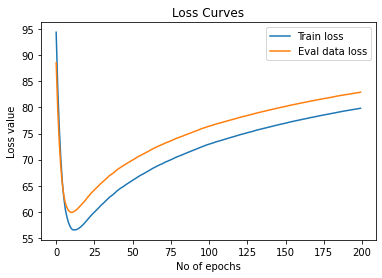

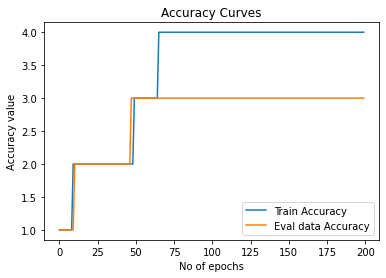

In [ ]:
print('Plots when regularization is included in single hidden layer model: \n')
plot_loss(trainloss, testloss, ep) 
plot_acc(trainacc, testacc, ep)

##This model which is built from scratch has the following problems:

*   Sigmoid activation function cannot capture the classification properly
*   The weights are randomly initialized, thus results are prone to changes during every run

##Thus we are going to implement this with the Keras API using the built in Dense functions to reassure ourself before moving to a bigger network model.



#FCN USING KERAS BUILT IN FUNCTIONS

In [ ]:
def split(xtrain, ytrain):
  x = xtrain.astype('float32')
  x = x[1000:1100]
  print(x.shape)
  y = ytrain[1000:1100]
  print(y.shape)
  xv = xtrain.astype('float32')
  xv = xv[:50]
  print(xv.shape)
  yv = ytrain[:50]
  print(yv.shape)
  return x/255.0, y, xv/255.0, yv

x, y, xv, yv = split(xtrain, ytrain)

(100, 32, 32, 3)
(100, 10)
(50, 32, 32, 3)
(50, 10)


####We have performed the rescaling operation in the function split(). Thus now, the training and testing data are rescaled to 0-1. 

####So here we will be implementing the softmax activation in the output layer and the relu in the Dense layer

In [ ]:
#Recreation of the model built from scratch using Keras layers

inp = Input(shape=(32, 32, 3))
model = Flatten()(inp)
model = Dense(200, activation='relu')(model)
op = Dense(10, activation='softmax', activity_regularizer = regularizers.l2(0.0001))(model)
FCN = Model(inp, op)
FCN.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 200)               614600    
_________________________________________________________________
dense_47 (Dense)             (None, 10)                2010      
Total params: 616,610
Trainable params: 616,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bs = 25
ep = 100
lr = [0.001, 0.01, 0.1]
loss = ['categorical_crossentropy']

####After some trials, it was observed that the learning rates did not seem suffiecient for the loss to go below 2.2 for training and 2.3 for validation. Thus, we implement Early stopping and Learning rate scheduling to autonmate the process, to see if these losses can be further brought down.

In [ ]:
sgd = SGD(learning_rate=0.0, momentum=0.9, nesterov=True)
rms=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
adam=Adam()
FCN.compile(optimizer=adam, loss=loss, metrics=['accuracy'])

In [ ]:
perform = FCN.fit(x, y, batch_size=25, epochs=ep, callbacks=get_callbacks(), validation_data=(xv, yv))

Train on 100 samples, validate on 50 samples
Epoch 1/100
100/100 [==============================] - 0s 905us/step - loss: 2.2726 - accuracy: 0.1000 - val_loss: 2.2477 - val_accuracy: 0.1200

Epoch 00001: val_loss improved from -inf to 2.24771, saving model to checkpoint_keras
Epoch 2/100
100/100 [==============================] - 0s 224us/step - loss: 2.2697 - accuracy: 0.1100 - val_loss: 2.2499 - val_accuracy: 0.1400

Epoch 00002: val_loss improved from 2.24771 to 2.24995, saving model to checkpoint_keras
Epoch 3/100
100/100 [==============================] - 0s 218us/step - loss: 2.2721 - accuracy: 0.1300 - val_loss: 2.2498 - val_accuracy: 0.1400

Epoch 00003: val_loss did not improve from 2.24995
Epoch 4/100
100/100 [==============================] - 0s 205us/step - loss: 2.2698 - accuracy: 0.1300 - val_loss: 2.2484 - val_accuracy: 0.1400

Epoch 00004: val_loss did not improve from 2.24995

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.005488116294145584.
Epoch 5/100
10

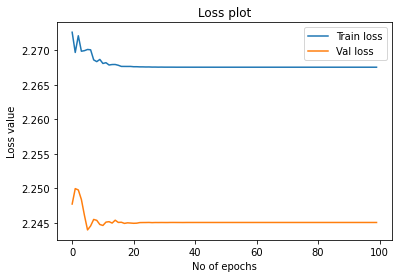

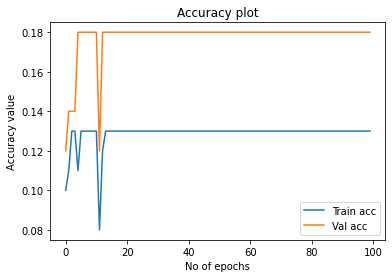

In [ ]:
plot_curves(perform)

#CNN for CIFAR10

In [ ]:
#Obtaining the data freshly for this model baysitting
x = xtrain
v = xtest
y = ytrain
yv = ytest
print(xtrain.shape)
print(ytrain.shape)
print(v.shape)
print(yv.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
#Performs datapreprocessing of rescaling and z-score:

def prep(x):
  #convert from integers to floats
	x_norm = x.astype('float32')
	# normalize to range 0-1
	x_norm = x_norm / 255.0
	# return normalized images
  #z-score
  mean = np.mean(x_norm,axis=(0,1,2,3))
  std = np.std(x_norm,axis=(0,1,2,3))
  x = (x_norm-mean)/(std+1e-7)
  
	return x

x = prep(x)#Train set
v = prep(v)#Test set

The VGG model is supposed to be a good start to a baseline CNN model fro image classification. In this model, they have implemented several blocks of the following combination-(Conv2d layer, Conv2d layer, Maxpooling layer, Dropout layer). Each of these have different filter sizes. Finally they are flattened and sent to a Dense layer. 

As a baseline model, we can check to see how the accuracy is by building just the first block of the VGG model as our baseline model. This is done in the cell below.

In [ ]:
#Building the basic model block of a CNN
def baseline():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
 
  opt = SGD(lr=0.001, momentum=0.5)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

In [ ]:
basemodel = baseline()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dense_55 (Dense)             (None, 10)                1290      
Total params: 1,060,138
Trainable params: 1,060,138
Non-trainable params: 0
____________________________________________

First we will fit the model with no prior augmentation techniques. Just that the values are all rescaled from 0-255 to 0-1 and the data is z-scored. The optimizer we will try is going to be SGD with a lr of 0.001 and momentum of 0.9. This is where we left off the previous model, and hence we will see how CNN responds to this. Loss used is the 'categorical cross entropy loss' as before. We will be training on the entire training set.

In [ ]:
#Hyperparameters: This contains, batchsize, number of epochs for now
bs = 64
ep = 100

In [ ]:
history = basemodel.fit(x, y, bs, ep, validation_data=(v, yv))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 4s 79us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
50000/50000 [==============================] - 4s 79us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
50000/50000 [==============================] - 4s 78us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
50000/50000 [==============================] - 4s 78us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
50000/50000 [==============================] - 4s 78us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
50000/50000 [==============================] - 4s 78us/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
50000/50000 [==============================] - 4s 

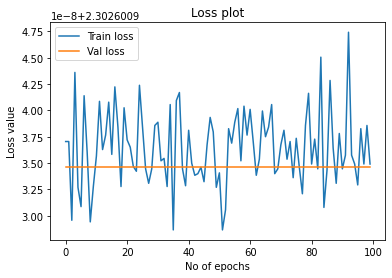

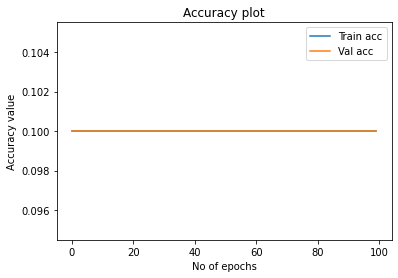

In [ ]:
plot_curves(history)

The above baseline model has not given any good results. The value of the loss is around the same and so is the accuracy. Thus, we now incorporate methods to regularize the model-kernel regularizer, Batch normalization. Callbacks to vary the learning rates. Add one layer of Dropout after the MaxPooling layer. Also we try the use of elu as activation, given that SGD isn't working.

In [ ]:
def model1():

  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3)) #Adding this to ensure more sparsity while training
  model.add(Dense(10, activation='softmax'))
 
  opt = SGD(lr=0.001, momentum=0.5)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

modelob = model1()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
flatten_35 (Flatten)         (None, 32768)           

In [ ]:
history = modelob.fit(x, y, bs, ep, validation_split=0.2, callbacks=[LearningRateScheduler(lr_schedule)])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 6s 149us/step - loss: 1.7698 - accuracy: 0.3724 - val_loss: 1.5550 - val_accuracy: 0.4555
Epoch 2/100
40000/40000 [==============================] - 6s 141us/step - loss: 1.4261 - accuracy: 0.4934 - val_loss: 1.3781 - val_accuracy: 0.5088
Epoch 3/100
40000/40000 [==============================] - 6s 141us/step - loss: 1.2850 - accuracy: 0.5441 - val_loss: 1.2657 - val_accuracy: 0.5523
Epoch 4/100
40000/40000 [==============================] - 6s 141us/step - loss: 1.1751 - accuracy: 0.5847 - val_loss: 1.2833 - val_accuracy: 0.5505
Epoch 5/100
40000/40000 [==============================] - 6s 141us/step - loss: 1.0839 - accuracy: 0.6184 - val_loss: 1.2880 - val_accuracy: 0.5501
Epoch 6/100
40000/40000 [==============================] - 6s 141us/step - loss: 1.0119 - accuracy: 0.6436 - val_loss: 1.1555 - val_accuracy: 0.5969
Epoch 7/100
40000/40000 [==============================]

By increasing the ability of the model to regularize better, we have achieved a fairly small training loss. However, the validation loss can be decreased further. Although it is in the decreasing phase, we may want to extend the number of epochs to verify. Also, further The model might be overfitting some data as the training accuracy has reached a 100% while the validation accuracy here is only 63%. This means that the model is learning but then it is also overfitting to some extent. Below are the loss and accuracy plota for the above model's performance.

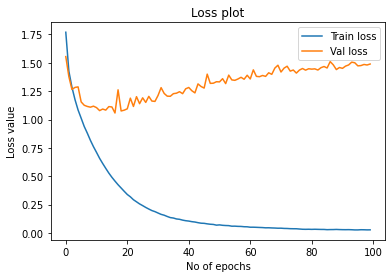

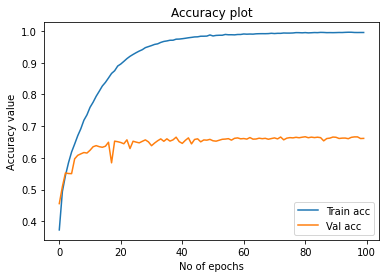

In [ ]:
plot_curves(history)

Now to further reduce the overfitting, what we do is add more blocks as in the model above and provide the model with data that is augmented well. This helps the model identify and generalize over a wider choice of data. The Augmentation techniques I have used are:


*   Rotation of the image

*   Lateral shift of the image
*   Vertical shift of the image


*   Horizontal flipping

These seem like the most appropriate methods of data augmentation that can be done.

Although SGD is well known and is known to give a good performance, I have tried the RMSprop optimizer. The activation used is 'elu'. This is because it make the cost converge to zero faster than a normal 'relu' activation.



In [ ]:
def model2():
  
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
 
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
 
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))
 
  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))
 
  model.summary()

  return model

model = model2()
  

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)      

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x)
 
#training
batch_size = 64
 
opt_rms = RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x, y, batch_size=batch_size),\
                    steps_per_epoch=x.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(v,yv),callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/125
781/781 [==============================] - 24s 31ms/step - loss: 1.9747 - accuracy: 0.4210 - val_loss: 1.6186 - val_accuracy: 0.5154
Epoch 2/125
781/781 [==============================] - 23s 30ms/step - loss: 1.4427 - accuracy: 0.5614 - val_loss: 1.3507 - val_accuracy: 0.6180
Epoch 3/125
781/781 [==============================] - 23s 30ms/step - loss: 1.2038 - accuracy: 0.6274 - val_loss: 1.1716 - val_accuracy: 0.6505
Epoch 4/125
781/781 [==============================] - 23s 30ms/step - loss: 1.0671 - accuracy: 0.6671 - val_loss: 0.9962 - val_accuracy: 0.6944
Epoch 5/125
781/781 [==============================] - 24s 30ms/step - loss: 0.9761 - accuracy: 0.6959 - val_loss: 0.9929 - val_accuracy: 0.7076
Epoch 6/125
781/781 [==============================] - 23s 29ms/step - loss: 0.9125 - accuracy: 0.7203 - val_loss: 0.9301 - val_accuracy: 0.7232
Epoch 7/125
781/781 [==============================] - 23s 30ms/step - loss: 0.8685 - accuracy: 0.7347 - val_loss: 0.8751 - val_ac

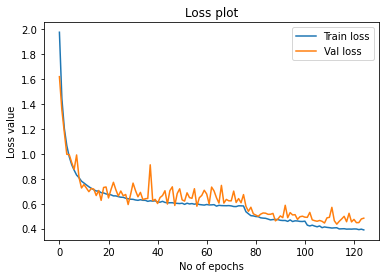

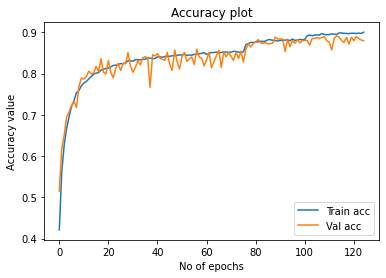

In [ ]:
plot_curves(history)

Thus this model gives us 88% Accuracy on the testing dataset. This is now completely better than the previous models. Thus this emphasizes that in order for a model to learn parameters of an image and classify them correctly:


*   We must give it sufficient amount of input
*   We must provide it with different types of data


*  Proivide good regularisation mechanisms
*  Choose correct hyperparameters 

Also, the model complexity is key here. The fact that we are providing so many Conv 2D layers each with different depts, we are enabling the model to learn more features than an ordinary Dense network (FCN) or a single block ConvNET.

The following provide the results of the model on the test data in terms of a Confusion Matrix and Classification Report.





In [ ]:
predict = model.predict(v, batch_size=batch_size)

In [ ]:
predict = np.argmax(predict, axis=1)
ytrue = np.argmax(yv, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion Matrix: \n{}'.format(confusion_matrix(ytrue, predict)))
print('Classification Report:\n {}'.format(classification_report(ytrue, predict)))

Confusion Matrix: 
[[893  11  16   3   8   0   7   3  38  21]
 [  3 964   0   0   1   0   2   0   4  26]
 [ 34   1 853   8  22  13  50  11   4   4]
 [ 15   9  35 679  39  54 109  25  16  19]
 [  4   1  29   6 887   1  56  11   3   2]
 [  3   3  35  78  36 747  53  31   7   7]
 [  7   0   8   5   2   0 971   1   4   2]
 [  7   0  12   9  35   6   9 914   3   5]
 [ 17  10   2   0   0   0   4   1 948  18]
 [  6  42   1   0   1   1   1   0   8 940]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      1000
           1       0.93      0.96      0.94      1000
           2       0.86      0.85      0.86      1000
           3       0.86      0.68      0.76      1000
           4       0.86      0.89      0.87      1000
           5       0.91      0.75      0.82      1000
           6       0.77      0.97      0.86      1000
           7       0.92      0.91      0.92      1000
           8       0.92      0.95      

In [ ]:
model.save('best_cnn_model.h5')

#Testing the Model on Face & Non-Face Data

In [ ]:
%cd 'CV_FaceDataset_Proj03/'

/content/drive/My Drive/CV_Project 03_skrish28/CV_FaceDataset_Proj03


In [ ]:
#Accessing the face dataset from drive using ImageDataGenerator

xdatafolder = '/content/drive/My Drive/CV_Project 03_skrish28/CV_FaceDataset_Proj03/Train'
vdatafolder = '/content/drive/My Drive/CV_Project 03_skrish28/CV_FaceDataset_Proj03/Test'

#dimensions of the image:
img_width, img_height, ch = 32, 32, 3
batch_size = 64
epochs = 100

face_gen = ImageDataGenerator(rescale=1./255, featurewise_center=1, featurewise_std_normalization=1,
                              horizontal_flip=True, rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, validation_split = 0.2,
                              brightness_range=(0.3, 0.9), shear_range=0.1)
face_test_gen = ImageDataGenerator(rescale=1./255)

train_face = face_gen.flow_from_directory(xdatafolder, target_size=(img_height, img_width),
                                          batch_size=batch_size, class_mode='categorical', subset='training')
val_face = face_gen.flow_from_directory(xdatafolder, target_size = (img_height, img_width), batch_size=batch_size, class_mode='categorical', subset='validation')

test_face = face_test_gen.flow_from_directory(vdatafolder, target_size = (img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 1610 images belonging to 2 classes.
Found 401 images belonging to 2 classes.
Found 201 images belonging to 2 classes.


In [ ]:
def modelf():
  
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
 
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))
 
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))
 
  model.add(Flatten())
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.4))
  model.add(Dense(2, activation='softmax'))
 
  model.summary()

  return model

nm = modelf()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)       

In [ ]:
batch_size = 64
 
opt_rms = RMSprop(lr=0.001,decay=1e-6)
nm.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = nm.fit_generator(train_face,\
                    steps_per_epoch=1000 // batch_size,epochs=100,\
                    verbose=1,validation_data=val_face,callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15/15 [==============================] - 4s 237ms/step - loss: 0.9237 - accuracy: 0.6656 - val_loss: 0.6137 - val_accuracy: 0.4988
Epoch 2/100
15/15 [==============================] - 3s 181ms/step - loss: 0.5757 - accuracy: 0.8083 - val_loss: 0.9414 - val_accuracy: 0.4988
Epoch 3/100
15/15 [==============================] - 3s 194ms/step - loss: 0.5574 - accuracy: 0.8135 - val_loss: 2.3392 - val_accuracy: 0.4988
Epoch 4/100
15/15 [==============================] - 3s 214ms/step - loss: 0.4468 - accuracy: 0.8448 - val_loss: 0.5966 - val_accuracy: 0.7082
Epoch 5/100
15/15 [==============================] - 3s 195ms/step - loss: 0.4213 - accuracy: 0.8587 - val_loss: 2.3198 - val_accuracy: 0.5012
Epoch 6/100
15/15 [==============================] - 3s 203ms/step - loss: 0.3721 - accuracy: 0.8698 - val_loss: 3.5116 - val_accuracy: 0.5012
Epoch 7/100
15/15 [==============================] - 3s 194ms/step - loss: 0.3017 - accuracy: 0.8996 - val_loss: 1.9285 - val_accuracy: 0.5187
Epoch 8/100

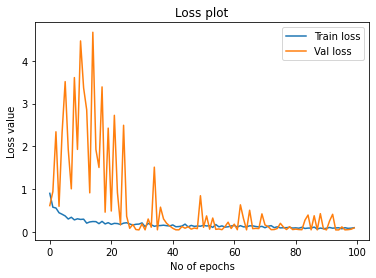

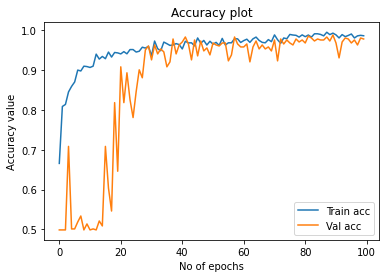

In [ ]:
plot_curves(history)

In [ ]:
predict = nm.predict_generator(test_face)

In [ ]:
ypred = np.argmax(predict,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print('Confusion matrix: \n{}'.format(confusion_matrix(test_face.classes, ypred)))
print('Classification report: \n{}'.format(classification_report(test_face.classes, ypred)))

Confusion matrix: 
[[55 45]
 [47 54]]
Classification report: 
              precision    recall  f1-score   support

           0       0.54      0.55      0.54       100
           1       0.55      0.53      0.54       101

    accuracy                           0.54       201
   macro avg       0.54      0.54      0.54       201
weighted avg       0.54      0.54      0.54       201

